读数据

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

In [2]:
train_data=pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
test_data=pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

In [3]:
train_data.shape

(1460, 81)

In [4]:
test_data.shape

(1459, 80)

In [5]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# 第一个特征是ID，它对预测房价没有帮助，因此我们将其从数据中移除。
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

In [7]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


预处理数据

In [8]:
# 将连续数值标准化
numeric_features=all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std())) 
# 标准化后，每个数值特征的均值变为0，所以我们可以固定一个0作为均值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [9]:
# 将离散数值转化为指示特征
all_features = pd.get_dummies(all_features, dummy_na=True) # dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
# get_dummies函数默认会将离散特征的每个取值都创建为布尔特征
all_features.shape

(2919, 331)

In [10]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [11]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

训练模型

In [12]:
loss=gloss.L2Loss()

def get_net():
    net=nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [13]:
def log_rmse(net, features, labels):
    # 将小于1的值设为1，使得对数运算更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2*loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()


In [28]:
def train(net, train_features, train_labels, test_features, test_labels,num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    # gdata.ArrayDataset(train_features, train_labels)创建一个数据集，gdata.DataLoader将数据集包装为一个迭代器，它每次迭代返回batch_size个样本
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay}) # Trainer类用于管理优化算法和相关的状态信息
    # 使用Adam优化算法，并传入优化算法所需的超参数
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_features is not None: 
            test_ls.append(log_rmse(net, test_features, test_labels))
        # print('epoch %d, train rmse %f, test rmse %f' % (epoch + 1, train_ls[-1], test_ls[-1]))
    return train_ls, test_ls

K折交叉验证

In [23]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0) # dim=0表示在第0维拼接
    return X_train, y_train, X_valid, y_valid

In [24]:
import d2lzh as d2l

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                     range(1, num_epochs + 1), valid_ls,
                     ['train', 'valid']) # semilogy函数绘制y轴对数坐标曲线
    return train_l_sum / k, valid_l_sum / k

模型选择

epoch 1, train rmse 3.742378, test rmse 3.756408
epoch 2, train rmse 3.061346, test rmse 3.075735
epoch 3, train rmse 2.663570, test rmse 2.677649
epoch 4, train rmse 2.383731, test rmse 2.397627
epoch 5, train rmse 2.167178, test rmse 2.180925
epoch 6, train rmse 1.992485, test rmse 2.006092
epoch 7, train rmse 1.845201, test rmse 1.858791
epoch 8, train rmse 1.718976, test rmse 1.732180
epoch 9, train rmse 1.608195, test rmse 1.621196
epoch 10, train rmse 1.509659, test rmse 1.522452
epoch 11, train rmse 1.421729, test rmse 1.434375
epoch 12, train rmse 1.342232, test rmse 1.354582
epoch 13, train rmse 1.269328, test rmse 1.281508
epoch 14, train rmse 1.202589, test rmse 1.214469
epoch 15, train rmse 1.141121, test rmse 1.152822
epoch 16, train rmse 1.084307, test rmse 1.095814
epoch 17, train rmse 1.031406, test rmse 1.042763
epoch 18, train rmse 0.981974, test rmse 0.993059
epoch 19, train rmse 0.935913, test rmse 0.946734
epoch 20, train rmse 0.892401, test rmse 0.903003
epoch 21,

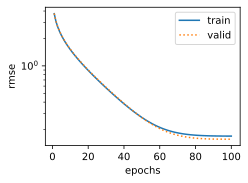

epoch 1, train rmse 3.736881, test rmse 3.747553
epoch 2, train rmse 3.058686, test rmse 3.069179
epoch 3, train rmse 2.662245, test rmse 2.672888
epoch 4, train rmse 2.382812, test rmse 2.393623
epoch 5, train rmse 2.167095, test rmse 2.178139
epoch 6, train rmse 1.991800, test rmse 2.002865
epoch 7, train rmse 1.844295, test rmse 1.855662
epoch 8, train rmse 1.718168, test rmse 1.729674
epoch 9, train rmse 1.607268, test rmse 1.618754
epoch 10, train rmse 1.509281, test rmse 1.520915
epoch 11, train rmse 1.421166, test rmse 1.433011
epoch 12, train rmse 1.341269, test rmse 1.353261
epoch 13, train rmse 1.268759, test rmse 1.280759
epoch 14, train rmse 1.202014, test rmse 1.214220
epoch 15, train rmse 1.140918, test rmse 1.153282
epoch 16, train rmse 1.083903, test rmse 1.096387
epoch 17, train rmse 1.030761, test rmse 1.043374
epoch 18, train rmse 0.981453, test rmse 0.994220
epoch 19, train rmse 0.935157, test rmse 0.948082
epoch 20, train rmse 0.891926, test rmse 0.904960
epoch 21,

In [25]:
k, num_epochs, learning_rate, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, learning_rate, weight_decay, batch_size)
print('%d-fold validation: average train rmse %f, average valid rmse %f' % (k, train_l, valid_l))

有时会发现一组参数的训练误差可以达到很低，但是K折交叉验证的误差却很高，这表明模型过拟合。

In [29]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, learning_rate, weight_decay, batch_size):
    net = get_net()
    train_ls,_= train(net, train_features, train_labels, None, None, num_epochs, learning_rate, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

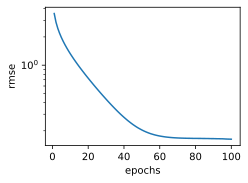

train rmse 0.162670


In [30]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs,learning_rate, weight_decay, batch_size)